# Exploring Structure in Chinese Noun Embeddings

---

This project investigates how Chinese nouns organise in embedding space, using clustering and dimensionality reduction to uncover underlying linguistic patterns. 

The goal was to explore whether semantic categories emerge naturally from contextual embeddings, and to what extent structural properties of Chinese, such as single-character morphology, influence the organisation of meaning.  

---

This notebook uses pre-computed clustering results exported from [**BERT_noun_clustering.ipynb**](BERT_noun_clustering.ipynb). The clustering file is not tracked in git but can be regenerated by running the other notebook.

## 3D Visualisation

In [1]:
from helper_functions import create_3d_cluster_visualisation

# Load clustering data
data_path = 'data/noun_clusters_BERT_top1000_pca100.pkl'

# Select and label clusters to display
cluster_labels = {
    2: "Places",
    8: "Body Parts",
    9: "Food",
    19: "Vehicles",
    22: "Family Members",
    23: "Animals",
    15: "Single Characters",
}

# Choose distinct colours for each cluster
color_map = {
    2: '#06B6D4',   # Cyan (Places)
    8: '#EF4444',   # Red (Body Parts)
    9: '#F59E0B',   # Amber (Food)
    19: '#10B981',  # Green (Vehicles)
    22: '#EC4899',  # Pink (Family Members)
    23: '#F97316',  # Orange (Animals)
    15: '#FFFFFF',  # White (Single Characters)
}

# Exclude outliers
words_to_exclude = ['引擎', '晚餐', '夫妇', '妈', '地球', '哥']

# Add title and subtitle
title = 'BERT Embedding Structure of Top 1000 Chinese Nouns'
subtitle = 'Agglomerative Clustering - 100 Principal Components'

# Create visualisation
fig = create_3d_cluster_visualisation(
    clustering_data=data_path,
    cluster_labels=cluster_labels,
    words_to_exclude=words_to_exclude,
    color_map=color_map,
    renderer='browser',
    title=title,
    subtitle=subtitle
)

/opt/anaconda3/envs/hanzi/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


![top_1000](images/BERT_top1000_pca100.png)

The visualisation displays a 3D projection of the 100-dimensional PCA space.

**Note:** Only 7 of the 28 clusters are shown. Word positions are scaled to 30% of their actual distance from cluster centroids to reduce visual clutter whilst preserving relative structure.

---

Single-character nouns form a distinct cluster at low PC1 values, whereas multi-character nouns occupy higher PC1 regions.

Interestingly, all three-character words in the visualisation appear exclusively in the Vehicles cluster, which has the highest PC1 value of all 7 clusters shown.

To quantify this relationship, the following analysis examines the correlation between PC1 and word length.

## Correlation Analysis

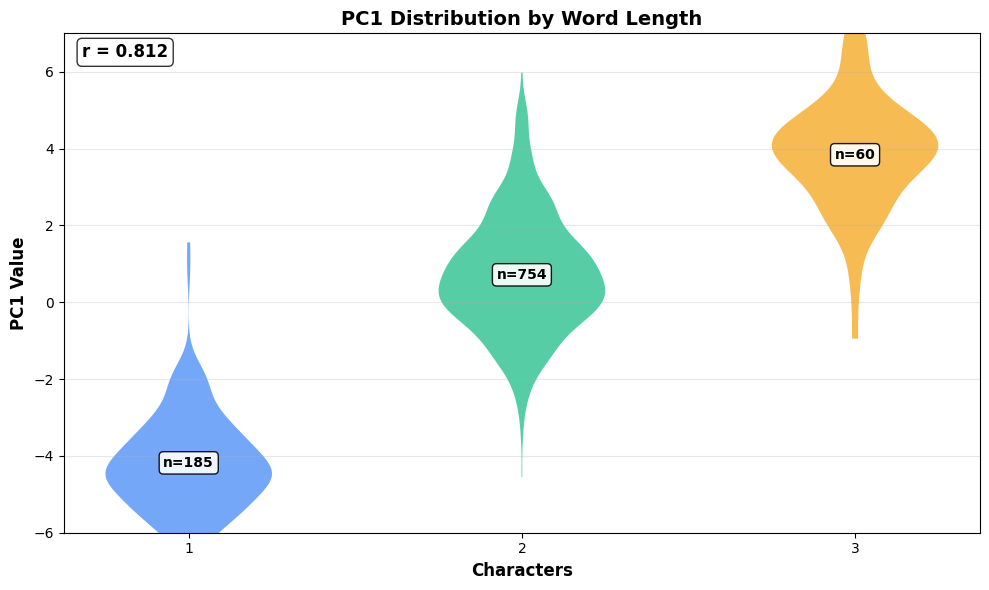

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

# Reload clustering results
with open(data_path, 'rb') as f:
    clustering_data = pickle.load(f)

# Extract the saved data
embeddings = clustering_data['embeddings']
nouns_df = clustering_data['nouns_df']

# Reduce the embeddings to three dimensions
pca_3d = PCA(n_components=3, random_state=42)
embeddings_3d = pca_3d.fit_transform(embeddings)

# Calculate word lengths and PC1 values
word_lengths = nouns_df['Noun'].str.len().values
pc1_values = embeddings_3d[:, 0]

# Filter out 4-character words
mask = word_lengths != 4
word_lengths = word_lengths[mask]
pc1_values = pc1_values[mask]

# Calculate correlation
correlation, p_value = pearsonr(pc1_values, word_lengths)

# Create DataFrame for easier plotting
df_plot = pd.DataFrame({
    'PC1': pc1_values,
    'Word Length': word_lengths
})

# Create violin plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
lengths = sorted(df_plot['Word Length'].unique())
data_by_length = [df_plot[df_plot['Word Length'] == l]['PC1'].values for l in lengths]
parts = ax.violinplot(data_by_length, positions=lengths, showmeans=False, showmedians=False, showextrema=False)
ax.set_xlabel('Characters', fontsize=12, fontweight='bold')
ax.set_ylabel('PC1 Value', fontsize=12, fontweight='bold')
ax.set_title('PC1 Distribution by Word Length', fontsize=14, fontweight='bold')
ax.set_xticks(lengths)
ax.set_ylim(-6, 7)
ax.grid(True, alpha=0.3, axis='y')

# Colour the violins
colors = ['#3B82F6', '#10B981', '#F59E0B']
for pc, color in zip(parts['bodies'], colors[:len(parts['bodies'])]):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

# Remove redundant error range lines
for partname in ('cbars', 'cmins', 'cmaxes'):
    if partname in parts:
        parts[partname].set_visible(False)

# Add sample size labels at the centre of each violin
for i, length in enumerate(lengths):
    n = len(data_by_length[i])
    mean_val = np.mean(data_by_length[i])
    ax.text(length, mean_val, f'n={n}', 
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

# Add correlation annotation
ax.text(0.02, 0.98, f'r = {correlation:.3f}', 
        transform=ax.transAxes, fontsize=12, fontweight='bold',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

PC1 in the 100-dimensional embedding space is strongly correlated with word length (**r = 0.812**). 

Visualised in 3D, this manifests as a morphological gradient along the PC1 axis. Single-character words cluster distinctly at low values, two-character words at intermediate values, and three-character words at the highest values. 

## Interpretation

**These results reveal that morphological complexity, rather than semantic similarity alone, is the dominant organising principle in how BERT represents Chinese nouns.**

Though single-character nouns exhibit high semantic diversity, they show surprisingly limited variance along other principal components. Two-character nouns, on the other hand, distribute across the full embedding space.

This suggests that morphological form acts as a primary constraint on representation, raising a key question: 

**Do single-character nouns retain semantic organisation within this compressed subspace, or does morphological encoding dominate entirely?**